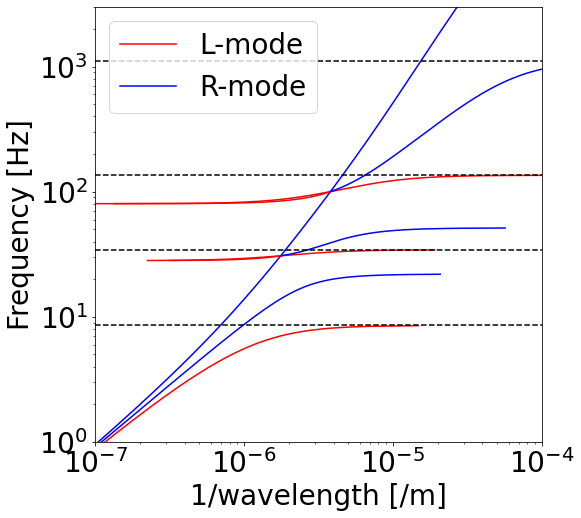

In [12]:

from calc_coldplasma_dispersion_relation import dispersion
import numpy as np
import matplotlib.pyplot as plt

nes = [60e6, 71e6, 128e6, 225e6, 173e6, 47e6] 
ion_ratio =  [[0.46, 0.11, 0.43],
              [0.30, 0.06, 0.64],
              [0.24, 0.08, 0.68],
              [0.14, 0.10, 0.76],
              [0.32, 0.19, 0.56],
              [0.29, 0.19, 0.52]]

ne=nes[0]
nh = ne*ion_ratio[0][0]
nhe= ne*ion_ratio[0][1]
no = ne*ion_ratio[0][2]
q = 1.602176634e-19
eps = 8.8541878128e-12
me = 9.1e-31
mh = 1.7e-27
mhe = 6.7e-27
mo = 2.7e-26

B0 = (8.53*2*np.pi*2.7e-26)/1.602176634e-19

omega_e = -q*B0/me
omega_h = q*B0/mh
omega_he = q*B0/mhe
omega_o = q*B0/mo

pi_e = (ne*q**2/(eps*me))**0.5
pi_h = (nh*q**2/(eps*mh))**0.5
pi_he = (nhe*q**2/(eps*mhe))**0.5
pi_o = (no*q**2/(eps*mo))**0.5

freq_range = np.arange(0.1, 3000, 0.1)
w_range = 2*np.pi*freq_range

wlh = (((pi_h)**2+(pi_he)**2+(pi_o)**2)/(1+(pi_e/omega_e)**2))**0.5

kL1, kL2, kR1, kR2, kl1, kl2 = dispersion(0, w_range, ne, nh, nhe, no, B0)
plt.figure(figsize=(8,8))
plt.rcParams["font.size"] = 28
plt.plot(kL1/(2*np.pi), freq_range, 'r', label='L-mode')
plt.plot(kL2/(2*np.pi), freq_range, 'r')
plt.plot(kR1/(2*np.pi), freq_range, 'b', label='R-mode')
plt.plot(kR2/(2*np.pi), freq_range, 'b')
kL1, kL2, kR1, kR2, kl1, kl2 = dispersion(np.pi/2, w_range, ne, nh, nhe, no, B0)
plt.plot(kL1/(2*np.pi), freq_range, 'r')
plt.plot(kL2/(2*np.pi), freq_range, 'r')
plt.plot(kR1/(2*np.pi), freq_range, 'b')
plt.plot(kR2/(2*np.pi), freq_range, 'b')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 3000)
plt.xlim(1e-7, 1e-4)
plt.hlines([omega_o/(2*np.pi), omega_he/(2*np.pi), omega_h/(2*np.pi), wlh/(2*np.pi)], xmin=1e-7, xmax=1e-2, colors='k', linestyles='dashed')
plt.xlabel('1/wavelength [/m]')
plt.ylabel('Frequency [Hz]')
plt.legend()

In [14]:
va = B0/np.sqrt(1.3e-6*(nh*mh+nhe*mhe+no*mo))
va

8925224.408010991

In [23]:
va = B0/np.sqrt(1.3e-6*(ne*mo))
va

6223763.574660223

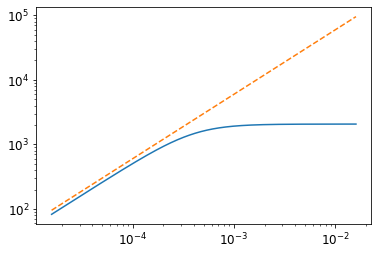

In [26]:
import numpy as np
import matplotlib.pyplot as plt

theta = np.deg2rad(30)
rho_i = 300
rambda_e = 800
k = np.arange(1e-4, 1e-1, 1e-5)
va = 6e6
omega = va*k*np.cos(theta)/np.sqrt(1+(k*np.sin(theta)*rambda_e)**2)
omega_va = va*k

plt.figure()
plt.rcParams["font.size"] = 12
plt.plot(k/(2*np.pi), omega/(2*np.pi))
plt.plot(k/(2*np.pi),omega_va/(2*np.pi), linestyle='dashed')
plt.yscale('log')
plt.xscale('log')

In [8]:

import numpy as np
a = np.arange(12).reshape(3,4)
a, a.T[1:3]

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]),
 array([[ 1,  5,  9],
        [ 2,  6, 10]]))

MCA plots including data interfered by sms

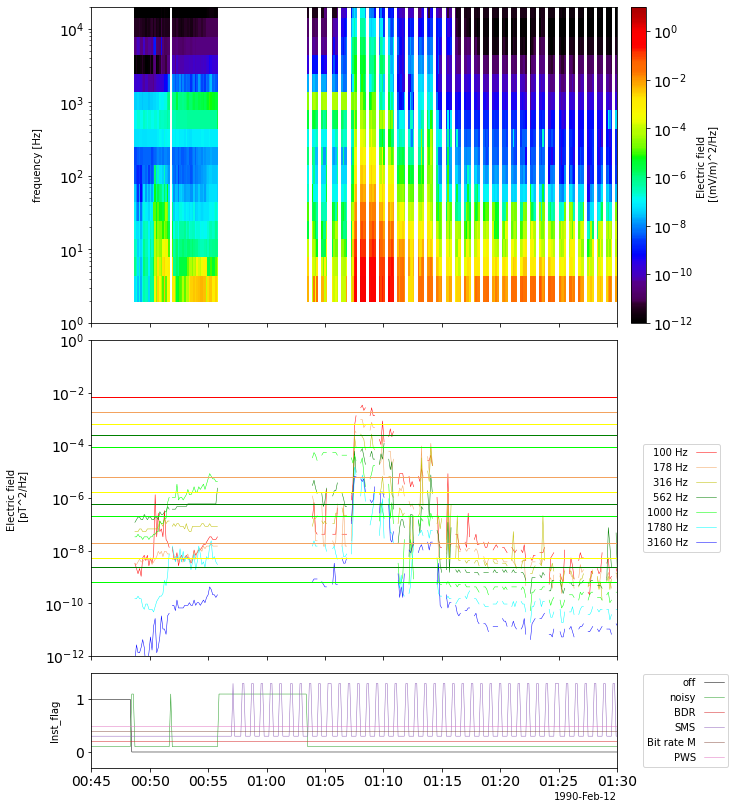

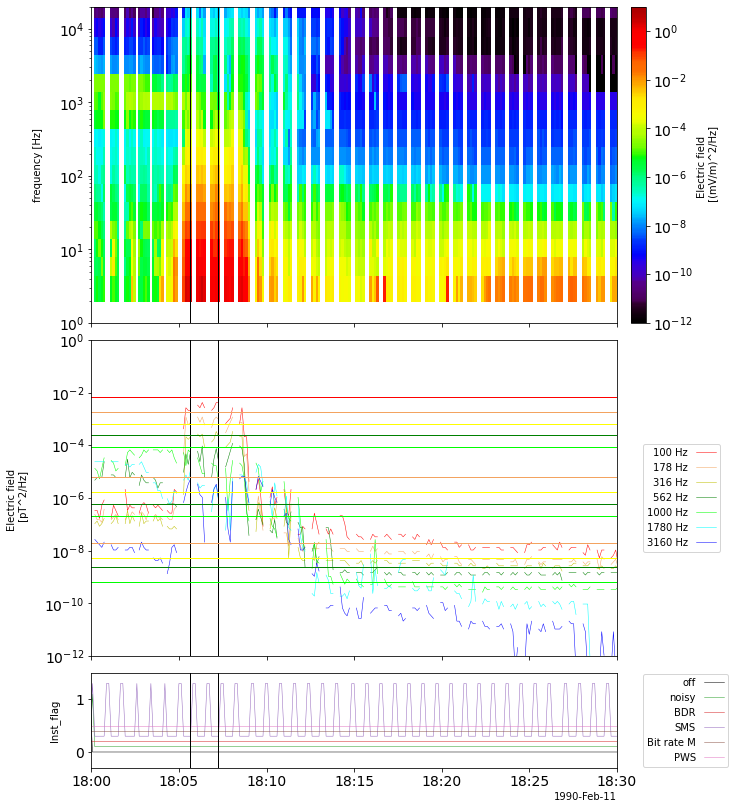

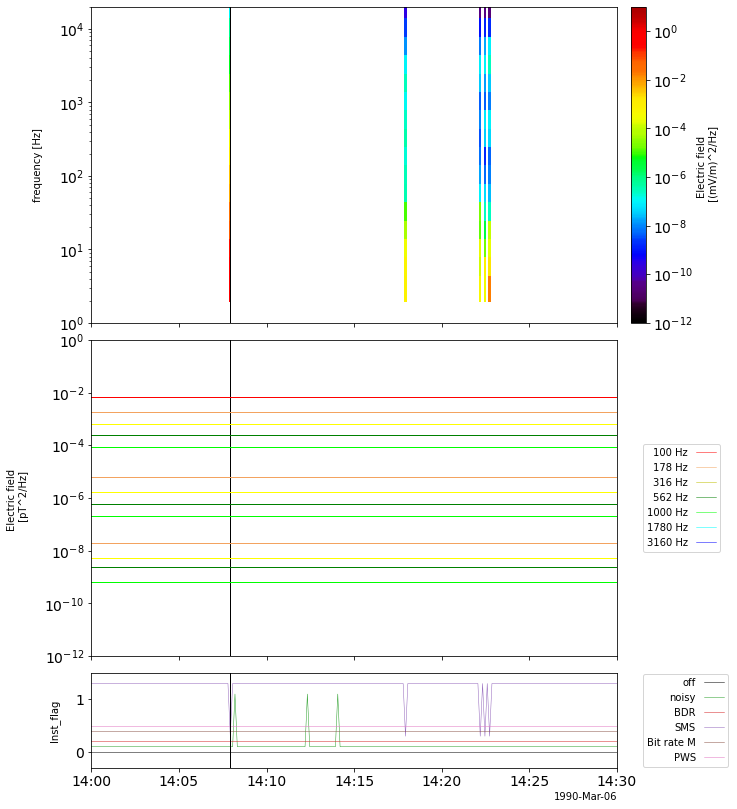

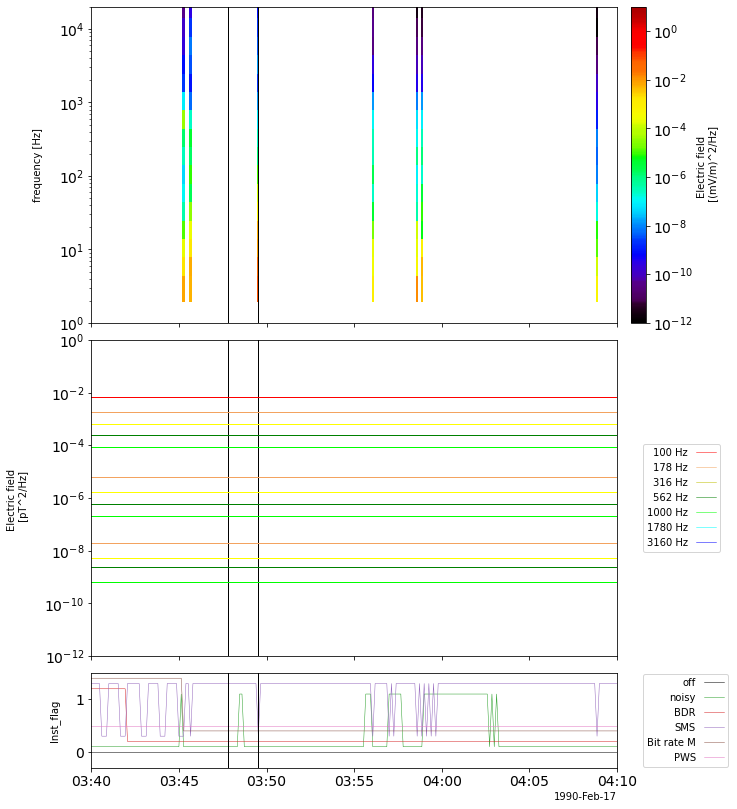

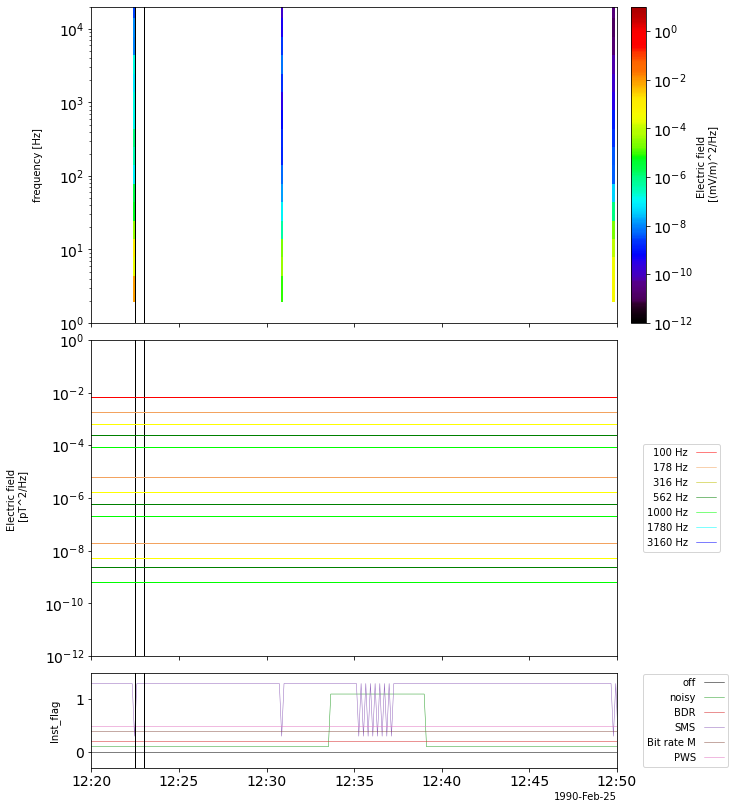

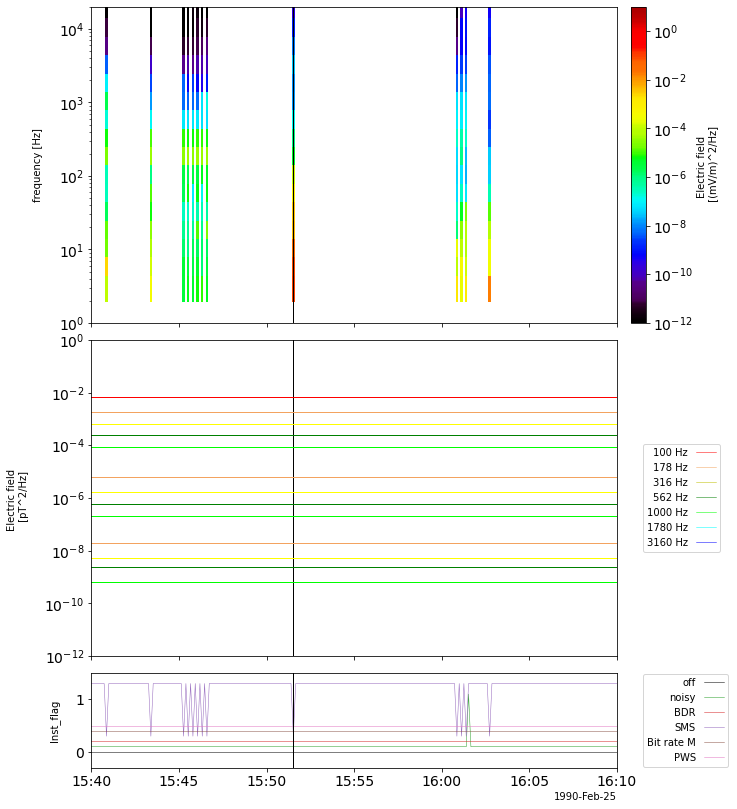

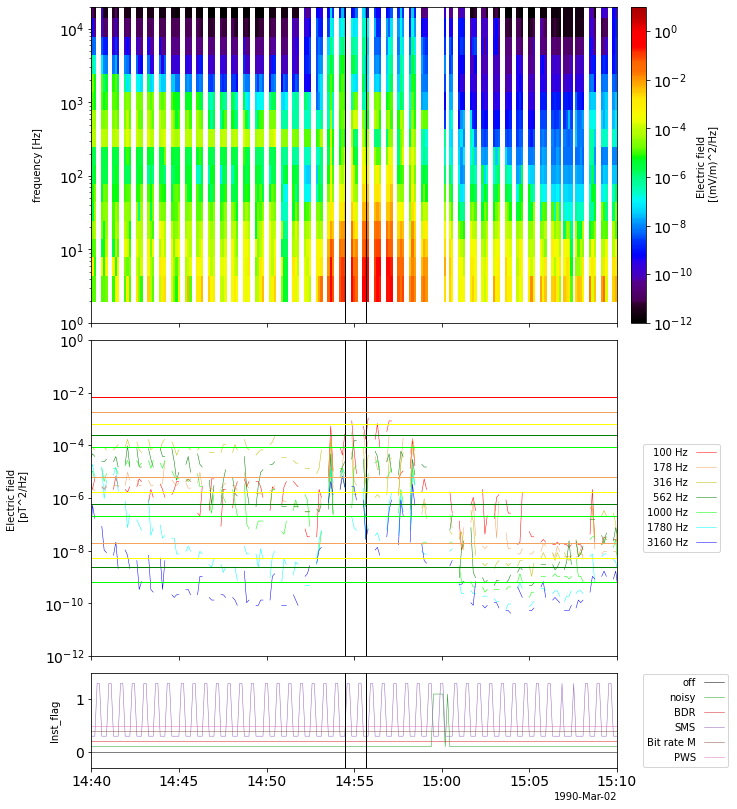

In [6]:
def ishigaya_event_noise_check_plot(date_range, time_limit, data_time, del_sms_interference):
    import load
    from pytplot import options, tlimit, timebar, store_data, get_data, tplot_options
    from pytplot.MPLPlotter.tplot import tplot
    import numpy as np
    freq_label = ['100 Hz', '178 Hz', '316 Hz', '562 Hz', '1000 Hz', '1780 Hz','3160 Hz']
    if del_sms_interference == 'off':
        load.mca(date_range, del_invalid_data=['off', 'noisy', 'bit rate m', 'pws', 'bdr'])
    if del_sms_interference == 'on':
        load.mca(date_range, del_invalid_data=['off', 'noisy', 'sms', 'bit rate m', 'pws', 'bdr'])        
    postgap = get_data('PostGap')
    postgap_array = np.empty([postgap.y.size, 6])
    for i in range(postgap.y.size):
        postgap_str = format(postgap.y[i], '08b')
        #"off"               "noisy",             "BDR",               "SMS",               "Bit rate",          "PWS",    
        postgap_array[i][0], postgap_array[i][1], postgap_array[i][2], postgap_array[i][3], postgap_array[i][4], postgap_array[i][5] = \
        int(postgap_str[7]), int(postgap_str[6])+0.1, int(postgap_str[3])+0.2, int(postgap_str[2])+0.3, int(postgap_str[1])+0.4, int(postgap_str[0])+0.5 
    value_type = 'max'
    B_tvar = get_data('B'+value_type+'_pwr')
    B_array = B_tvar.y.T
    B_array_100_3160 = B_array[6:13]
    store_data('B'+value_type+'_pwr_100_3160', data={'x':B_tvar.times, 'y':B_array_100_3160.T})
    store_data('Inst_flag', data = {'x':postgap.times, 'y':postgap_array})
    options('B'+value_type+'_pwr_100_3160', opt_dict={'ylog':True, 'legend_names':freq_label, 'legend_location':'spedas', 'ytitle':'Magnetic field \n [pT^2/Hz]',
                                'yrange':[1e-8, 1], 'color':['r', 'orangered', 'y', 'g', 'lime','cyan','b'], 'marker':','})
    
    E_tvar = get_data('E'+value_type+'_pwr')
    E_array = E_tvar.y.T
    E_array_100_3160 = E_array[6:13]
    store_data('E'+value_type+'_pwr_100_3160', data={'x':E_tvar.times, 'y':E_array_100_3160.T})
    options('E'+value_type+'_pwr_100_3160', opt_dict={'ylog':True, 'legend_names':freq_label, 'legend_location':'spedas', 'ytitle':'Electric field \n [pT^2/Hz]',
                                'yrange':[1e-12, 1], 'color':['r', 'sandybrown', 'y', 'g', 'lime','cyan','b'], 'marker':','})
    
    options('Inst_flag', opt_dict={'yrange':[-0.3, 1.5], 'panel_size':0.3})
    options('Inst_flag', opt_dict={'legend_names':['off', 'noisy', 'BDR', 'SMS', 'Bit rate M', 'PWS'], 'legend_location':'spedas'})
    options('B'+value_type+'_pwr', opt_dict={'spec':True, 'ylog':True, 'ytitle':'frequency [Hz]', 'yrange':[1, 20000], 'zlog':True, 'ztitle':'Magnetic field \n [pT^2/Hz]', 'zrange':[1e-8,1e6]})
    options('E'+value_type+'_pwr', opt_dict={'spec':True, 'ylog':True, 'ytitle':'frequency [Hz]', 'yrange':[1, 20000], 'zlog':True, 'ztitle':'Electric field \n [(mV/m)^2/Hz]', 'zrange':[1e-12,10]})
    tlimit(time_limit)
    timebar(data_time)

    timebar(6.65e-3, varname='E'+value_type+'_pwr_100_3160', databar=True, color='r')
    timebar([1.89e-8, 5.99e-6, 1.89e-3], varname='E'+value_type+'_pwr_100_3160', databar=True, color='sandybrown')
    timebar([5.28678516e-09, 1.67182826e-06, 6.65566819e-04], varname='E'+value_type+'_pwr_100_3160', databar=True, color='y')
    timebar([2.36125249e-09, 5.93119810e-07, 2.36125249e-04], varname='E'+value_type+'_pwr_100_3160', databar=True, color='g')
    timebar([6.65087438e-10, 2.10319115e-07, 8.37295477e-05], varname='E'+value_type+'_pwr_100_3160', databar=True, color='lime')
    
    tplot_options('axis_font_size', 14)
    #tplot(['Eave_pwr', 'Eave_pwr_100_3160','Bave_pwr', 'Bave_pwr_100_3160', 'Inst_flag'], xsize=8, ysize=14)
    tplot(['E'+value_type+'_pwr', 'E'+value_type+'_pwr_100_3160', 'Inst_flag'], xsize=10, ysize=14)
    
date_range_list = [['1990-02-12', '1990-02-13'],
                   ['1990-02-11', '1990-02-12'],
                    ['1990-03-06', '1990-03-07'],
                    ['1990-02-17', '1990-02-18'],
                    ['1990-02-25', '1990-02-26'],
                    ['1990-02-25', '1990-02-26'],
                    ['1990-03-02', '1990-03-03']]
time_limit_list = [['1990-02-12 0:45:00', '1990-02-12 1:30:00'],
                   ['1990-02-11 18:00:00', '1990-02-11 18:30:00'],
                   ['1990-03-06 14:00:00', '1990-03-06 14:30:00'],
                   ['1990-02-17 03:40:00', '1990-02-17 04:10:00'],
                   ['1990-02-25 12:20:00', '1990-02-25 12:50:00'],
                   ['1990-02-25 15:40:00', '1990-02-25 16:10:00'],
                   ['1990-03-02 14:40:00', '1990-03-02 15:10:00']]
event_time_list =  [['1990-02-11 18:05:39', '1990-02-11 18:07:15'],
                    ['1990-02-11 18:05:39', '1990-02-11 18:07:15'],
                ['1990-03-06 14:07:56', '1990-03-06 14:07:56'],
                ['1990-02-17 03:49:30', '1990-02-17 03:47:48'],
                ['1990-02-25 12:22:30', '1990-02-25 12:23:00'],
                ['1990-02-25 15:51:32', '1990-02-25 15:51:32'],
                ['1990-03-02 14:54:28', '1990-03-02 14:55:40']]
for i in range(7):
    ishigaya_event_noise_check_plot(date_range_list[i], time_limit_list[i], event_time_list[i], del_sms_interference='on')

In [96]:
import pyspedas, pytplot, load
from pytplot import get_data
import numpy as np
from calc_coldplasma_dispersion_relation import dispersion
import matplotlib.pyplot as plt
q = 1.602176634e-19
eps = 8.8541878128e-12
me = 9.1e-31
mh = 1.7e-27
mhe = 6.7e-27
mo = 2.7e-26
tranges = [['1990-02-11', '1990-02-12'],
           ['1990-03-06', '1990-03-07'],
           ['1990-02-17', '1990-02-18'],
           ['1990-02-25', '1990-02-26'],
           ['1990-02-25', '1990-02-26'],
           ['1990-03-02', '1990-03-03']]

event_times =  [pyspedas.time_double('1990-02-11 18:05:39'),pyspedas.time_double('1990-02-11 18:07:15'),
                pyspedas.time_double('1990-03-06 14:07:56'),pyspedas.time_double('1990-03-06 14:07:56'),
                pyspedas.time_double('1990-02-17 03:49:30'),pyspedas.time_double('1990-02-17 03:47:48'),
                pyspedas.time_double('1990-02-25 12:22:30'),pyspedas.time_double('1990-02-25 12:23:00'),
                pyspedas.time_double('1990-02-25 15:51:32'),pyspedas.time_double('1990-02-25 15:51:32'),
                pyspedas.time_double('1990-03-02 14:54:28'),pyspedas.time_double('1990-03-02 14:55:40')]

nes = [60e6, 71e6, 128e6, 225e6, 173e6, 47e6] 
ion_ratio =  [[0.46, 0.11, 0.43],
              [0.30, 0.06, 0.64],
              [0.24, 0.08, 0.68],
              [0.14, 0.10, 0.76],
              [0.32, 0.19, 0.56],
              [0.29, 0.19, 0.52]]

Vph_obs = []
Vph_dr  = []
Vph_ratio = []
Eobs = []
Bobs = []
event_time_list = []
for i in range(6):
    trange = tranges[i]
    event_time1 = pyspedas.time_double(event_times[2*i])
    event_time2 = pyspedas.time_double(event_times[2*i+1])

    ne = nes[i]
    nh = ne*ion_ratio[i][0]
    nhe= ne*ion_ratio[i][1]
    no = ne*ion_ratio[i][2]

    load.mca(trange, del_invalid_data=['off', 'noisy', 'sms', 'bdr', 'bit rate m', 'pws'])
    load.orb(trange)
    tplot_names = ['Emax', 'Eave', 'Bmax', 'Bave']
    for j in range(4):
        tplot_variable = pytplot.get_data(tplot_names[j])
        tplot_variable_float = (tplot_variable.y).astype(float)
        np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
        tplot_variable_0dB = 1e-6 #mV or pT
        bandwidth = tplot_variable.v * 0.3
        tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)
        tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2)
        pytplot.store_data(tplot_names[j] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
        pytplot.store_data(tplot_names[j] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
    
    Eamp = pytplot.get_data('Emax_Amp')
    Epwr = pytplot.get_data('Emax_Pwr')

    Bamp = pytplot.get_data('Bmax_Amp')

    Times = Eamp.times

    pyspedas.tinterpol('akb_Bmdl_X', interp_to='Emax_Pwr', newname = 'Bmdl_x')
    pyspedas.tinterpol('akb_Bmdl_Y', interp_to='Emax_Pwr', newname = 'Bmdl_y')
    pyspedas.tinterpol('akb_Bmdl_Z', interp_to='Emax_Pwr', newname = 'Bmdl_z')

    Bx = pytplot.get_data('Bmdl_x')
    By = pytplot.get_data('Bmdl_y')
    Bz = pytplot.get_data('Bmdl_z')
    B = np.sqrt(Bx.y**2 + By.y**2 + Bz.y**2) * 1e-9 


    Epwr_10Hz = Epwr.y.T[2]

    idx1 = np.argmin(np.abs(Times - event_time1))
    idx2 = np.argmin(np.abs(Times - event_time2))

    Eamp = [Eamp.y[idx1], Eamp.y[idx2]]
    Bamp = [Bamp.y[idx1], Bamp.y[idx2]]

    B0 = [B[idx1], B[idx2]]
    
    pi_e = (ne*q**2/(eps*me))**0.5
    pi_h = (nh*q**2/(eps*mh))**0.5
    pi_he = (nhe*q**2/(eps*mhe))**0.5
    pi_o = (no*q**2/(eps*mo))**0.5

    omega_e = -q*B0[0]/me

    wlh = (((pi_h)**2+(pi_he)**2+(pi_o)**2)/(1+(pi_e/omega_e)**2))**0.5
    print(wlh/(2*np.pi))
    freq_range = Epwr.v
    w_range = 2*np.pi*freq_range
    print(pyspedas.time_string(Times[idx1], fmt='%Y-%m-%d %H:%M:%S'), pyspedas.time_string(Times[idx2], fmt='%Y-%m-%d %H:%M:%S'))
    event_time_list.append([pyspedas.time_string(Times[idx1], fmt='%Y-%m-%d %H:%M:%S'), pyspedas.time_string(Times[idx2], fmt='%Y-%m-%d %H:%M:%S')])
    theta = np.deg2rad(80)
    for k in range(2):
        kL1, kL2, kR1, kR2, kl1, kl2 = dispersion(theta, w_range, ne, nh, nhe, no, B0[k])
        Vph_dr.append((w_range/kR2).tolist())
        Vph_obs.append((Eamp[k]/Bamp[k] *1e9).tolist())
        Eobs.append(Eamp[k].tolist())
        Bobs.append(Bamp[k].tolist())

20-Oct-22 00:44:34: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)

20-Oct-22 00:44:34: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:72: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey2 = j*d*(p - N2*(np.sin(theta))**2)/(s*p - s*N2*(np.sin(theta))**2 - p*N2*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1112.5551346605491
1990-02-11 18:05:40 1990-02-11 18:07:16


20-Oct-22 00:44:35: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)

20-Oct-22 00:44:35: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:72: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey2 = j*d*(p - N2*(np.sin(theta))**2)/(s*p - s*N2*(np.sin(theta))**2 - p*N2*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
943.9806788182502
1990-03-06 14:07:56 1990-03-06 14:07:56


20-Oct-22 00:44:35: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)

20-Oct-22 00:44:35: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:72: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey2 = j*d*(p - N2*(np.sin(theta))**2)/(s*p - s*N2*(np.sin(theta))**2 - p*N2*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1058.5842431479944
1990-02-17 03:49:32 1990-02-17 03:47:48


20-Oct-22 00:44:36: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1168.991038088252
1990-02-25 12:22:28 1990-02-25 12:23:00


20-Oct-22 00:44:36: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)

20-Oct-22 00:44:36: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:72: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey2 = j*d*(p - N2*(np.sin(theta))**2)/(s*p - s*N2*(np.sin(theta))**2 - p*N2*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1440.272983201852
1990-02-25 15:51:32 1990-02-25 15:51:32


20-Oct-22 00:44:37: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)

20-Oct-22 00:44:37: /Document/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:72: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey2 = j*d*(p - N2*(np.sin(theta))**2)/(s*p - s*N2*(np.sin(theta))**2 - p*N2*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
815.3000073947256
1990-03-02 14:54:28 1990-03-02 14:55:40


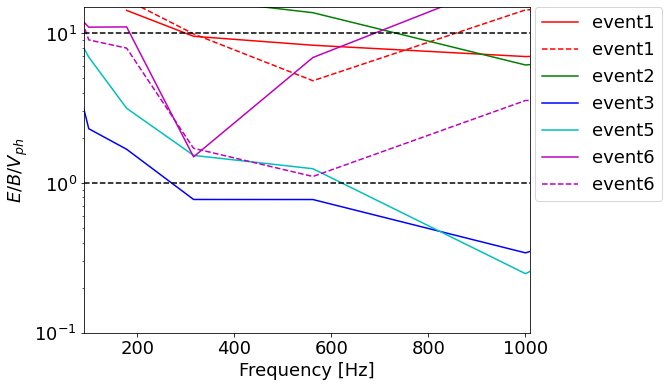

In [97]:

Vph_ratio = np.array(Vph_obs)/np.array(Vph_dr)
colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(8, 6))
plt.rcParams['font.size'] = 18
'''
plt.plot(freq_range, Vph_ratio[0], label='event1' + ' ' + event_time_list[0][0], color=colorlist[0])
plt.plot(freq_range, Vph_ratio[1], label='event1' + ' ' + event_time_list[0][1], color=colorlist[0], linestyle='dashed')
plt.plot(freq_range, Vph_ratio[2], label='event2' + ' ' + event_time_list[1][0], color=colorlist[1])
plt.plot(freq_range, Vph_ratio[4], label='event3' + ' ' + event_time_list[2][0], color=colorlist[2])
plt.plot(freq_range, Vph_ratio[8], label='event5' + ' ' + event_time_list[4][0], color=colorlist[3])
plt.plot(freq_range, Vph_ratio[10], label='event6' + ' ' + event_time_list[5][0], color=colorlist[4])
plt.plot(freq_range, Vph_ratio[11], label='event6' + ' ' + event_time_list[5][1], color=colorlist[4], linestyle='dashed')
'''
plt.plot(freq_range, Vph_ratio[0], label='event1', color=colorlist[0])
plt.plot(freq_range, Vph_ratio[1], label='event1', color=colorlist[0], linestyle='dashed')
plt.plot(freq_range, Vph_ratio[2], label='event2', color=colorlist[1])
plt.plot(freq_range, Vph_ratio[4], label='event3', color=colorlist[2])
plt.plot(freq_range, Vph_ratio[8], label='event5', color=colorlist[3])
plt.plot(freq_range, Vph_ratio[10], label='event6', color=colorlist[4])
plt.plot(freq_range, Vph_ratio[11], label='event6', color=colorlist[4], linestyle='dashed')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$E/B / V_{ph}$')
plt.ylim(0.1,15)
plt.xlim(90, 1010)
plt.hlines(1, xmin=90, xmax=1010, colors='k', linestyles='dashed')
plt.hlines(10, xmin=90, xmax=1010, colors='k', linestyles='dashed')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
#plt.title(str(np.rad2deg(theta)) + ' [rad]')


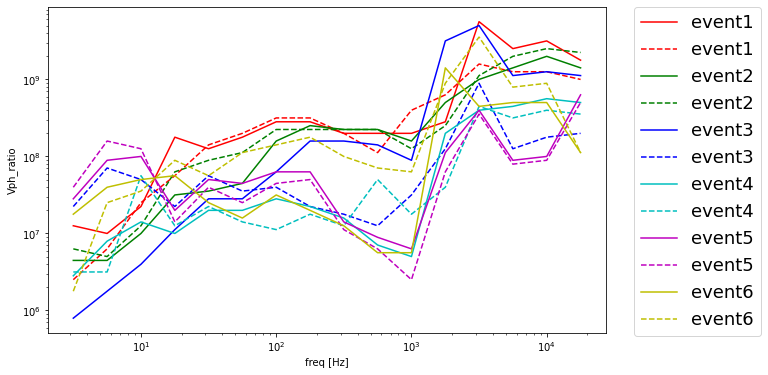

In [5]:
colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(freq_range, Vph_obs[2*i], label='event'+str(i+1), color=colorlist[i])
    plt.plot(freq_range, Vph_obs[2*i+1], label='event'+str(i+1), color=colorlist[i], linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Vph_ratio')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

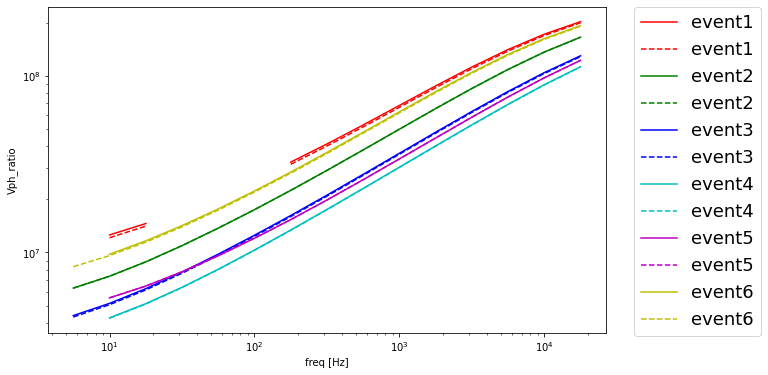

In [5]:
colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(freq_range, Vph_dr[2*i], label='event'+str(i+1), color=colorlist[i])
    plt.plot(freq_range, Vph_dr[2*i+1], label='event'+str(i+1), color=colorlist[i], linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Vph_ratio')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

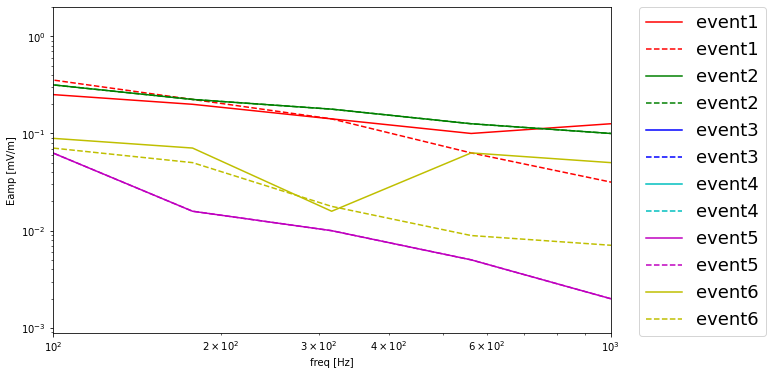

In [3]:

colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(freq_range, Eobs[2*i], label='event'+str(i+1), color=colorlist[i])
    plt.plot(freq_range, Eobs[2*i+1], label='event'+str(i+1), color=colorlist[i], linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Eamp [mV/m]')
plt.xlim(100, 1000)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

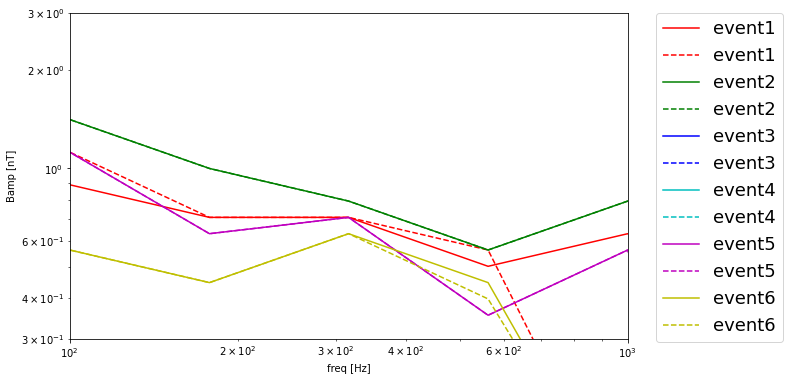

In [4]:
colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(freq_range, Bobs[2*i], label='event'+str(i+1), color=colorlist[i])
    plt.plot(freq_range, Bobs[2*i+1], label='event'+str(i+1), color=colorlist[i], linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Bamp [nT]')
plt.xlim(100, 1000)
plt.ylim(0.3, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

Ishigaya event plot

In [ ]:
import pyspedas, pytplot, load
from pytplot import get_data
import numpy as np
from calc_coldplasma_dispersion_relation import dispersion
import matplotlib.pyplot as plt

tranges = [['1990-02-11', '1990-02-12'],
           ['1990-03-06', '1990-03-07'],
           ['1990-02-17', '1990-02-18'],
           ['1990-02-25', '1990-02-26'],
           ['1990-02-25', '1990-02-26'],
           ['1990-03-02', '1990-03-03']]

event_times =  [pyspedas.time_double('1990-02-11 18:05:39'),
                pyspedas.time_double('1990-02-11 18:07:15'),
                pyspedas.time_double('1990-03-06 14:06:20'),
                pyspedas.time_double('1990-03-06 14:07:56'),
                pyspedas.time_double('1990-02-17 03:45:56'),
                pyspedas.time_double('1990-02-17 03:47:48'),
                pyspedas.time_double('1990-02-25 12:22:44'),
                pyspedas.time_double('1990-02-25 12:23:00'),
                pyspedas.time_double('1990-02-25 15:49:32'),
                pyspedas.time_double('1990-02-25 15:51:24'),
                pyspedas.time_double('1990-03-02 14:54:04'),
                pyspedas.time_double('1990-03-02 14:54:44')]

nes = [60e6, 71e6, 128e6, 225e6, 173e6, 47e6] 
ion_ratio =  [[0.46, 0.11, 0.43],
              [0.30, 0.06, 0.64],
              [0.24, 0.08, 0.68],
              [0.14, 0.10, 0.76],
              [0.32, 0.19, 0.56],
              [0.29, 0.19, 0.52]]

Vph_obs = []
Vph_dr  = []
Vph_ratio = []


for i in range(6):
    trange = tranges[i]
    event_time1 = pyspedas.time_double(event_times[2*i])
    event_time2 = pyspedas.time_double(event_times[2*i+1])

    load.mca(trange)
    load.orb(trange)
    tplot_names = ['Emax', 'Eave', 'Bmax', 'Bave']
    for j in range(4):
        tplot_variable = pytplot.get_data(tplot_names[j])
        tplot_variable_float = (tplot_variable.y).astype(float)
        np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
        tplot_variable_0dB = 1e-6 #mV or pT
        bandwidth = tplot_variable.v * 0.3
        tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)
        tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2)
        pytplot.store_data(tplot_names[j] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
        pytplot.store_data(tplot_names[j] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
    
    Eamp = pytplot.get_data('Emax_Amp')
    Epwr = pytplot.get_data('Emax_Pwr')

    Bamp = pytplot.get_data('Bmax_Amp')

    Times = Eamp.times
    #Time interpolate
    try:
        pyspedas.tinterpol('akb_ILAT', interp_to='Emax_Pwr', newname = 'ILAT')
    except:
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        print('orbit file is not perfect')
        continue
    pyspedas.tinterpol('akb_MLAT', interp_to='Emax_Pwr', newname = 'MLAT')
    pyspedas.tinterpol('akb_Pass', interp_to='Emax_Pwr', newname = 'Pass', method = 'nearest')
    pyspedas.tinterpol('akb_ALT', interp_to='Emax_Pwr', newname = 'ALT')
    pyspedas.tinterpol('akb_MLT', interp_to='Emax_Pwr', newname = 'MLT', method = 'nearest')
    pytplot.tplot()
    

In [8]:
import numpy as np

a = np.array([0, 5, 2, np.nan, 5])
maxIndex = [i for i, x in enumerate(a) if x == np.nanmax(a)]
print(maxIndex)    # [1, 4]

[1, 4]


In [30]:
import pyspedas
import pytplot
from pytplot import get_data, store_data
import numpy as np
from load import mca, orb
import matplotlib.pyplot as plt

ILAT_min = 55
start_day_string = '1990-01-05'
start_day_time_double = pyspedas.time_double(start_day_string)
days = 180

seconds_per_day = 86400
day_list = []
for i in range(0, days+1):
    time_double = start_day_time_double + i * seconds_per_day
    day_list.append(pyspedas.time_string(time_double, fmt='%Y-%m-%d %H:%M:%S'))

Emax_pwr_10Hz_array = np.empty((0,0), float)
Emax_amp_176Hz_array = np.empty((0,0), float)
Emax_amp_316Hz_array = np.empty((0,0), float)
Emax_amp_562Hz_array = np.empty((0,0), float)

Bmax_amp_176Hz_array = np.empty((0,0), float)
Bmax_amp_316Hz_array = np.empty((0,0), float)
Bmax_amp_562Hz_array = np.empty((0,0), float)

E_to_B_176Hz_array = np.empty((0,0), float)
E_to_B_316Hz_array = np.empty((0,0), float)
E_to_B_562Hz_array = np.empty((0,0), float)

Emax_pwr_mean_fcH_fLH_array = np.empty((0,0), float)

for k in range(len(day_list)-1):
    
    trange = [day_list[k], day_list[k+1]]
    print(trange)
    try:
        mca(trange= trange)
    except Exception as e:
        print(e)
        continue
    try:
        orb(trange= trange)
    except Exception as e:
        print(e)
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        
        #print('orbit file does not exists')
        continue
    
    tplot_names = pytplot.tplot_names(True)

    #dB to amplitude
    for i in range(4):
        tplot_variable = pytplot.get_data(tplot_names[i])
        tplot_variable_float = (tplot_variable.y).astype(float)
        np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
        tplot_variable_0dB = 1e-6 #mV or pT
        bandwidth = tplot_variable.v * 0.3
        tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)
        tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2) 
        pytplot.store_data(tplot_names[i] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
        pytplot.store_data(tplot_names[i] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
    
    #Time interpolate
    try:
        pyspedas.tinterpol('akb_ILAT', interp_to='Emax_Pwr', newname = 'ILAT')
    except:
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        print('orbit file is not perfect')
        continue
    pyspedas.tinterpol('akb_MLAT', interp_to='Emax_Pwr', newname = 'MLAT')
    pyspedas.tinterpol('akb_Pass', interp_to='Emax_Pwr', newname = 'Pass', method = 'nearest')
    pyspedas.tinterpol('akb_ALT', interp_to='Emax_Pwr', newname = 'ALT')
    pyspedas.tinterpol('akb_MLT', interp_to='Emax_Pwr', newname = 'MLT', method = 'nearest')
    #Limit ILAT range
    Emax = get_data('Emax_Pwr')
    time = Emax.times
    ILAT = get_data('ILAT')
    ILAT = ILAT.y
    MLAT = get_data('MLAT')
    MLAT = MLAT.y
    MLT = get_data('MLT')
    MLT = MLT.y

    Emax_pwr = get_data('Emax_Pwr')
    Emax_amp = get_data('Emax_Amp')
    Bmax_amp = get_data('Bmax_Amp')
    
    E_to_B = Emax_amp.y/Bmax_amp.y *1e9
    
    index_tuple = np.where((ILAT > 55)&(10 < MLT)&(MLT < 14))
    Emax_in_cusp = Emax_pwr.y[index_tuple[0]]
    Eamp_in_cusp = Emax_amp.y[index_tuple[0]]
    Bamp_in_cusp = Bmax_amp.y[index_tuple[0]]
    
    E_to_B_in_cusp = E_to_B[index_tuple[0]]
            
    Emax_10Hz = Emax_in_cusp.T[2]
    Eamp_176Hz_562Hz = Eamp_in_cusp.T[7:10]
    Bamp_176Hz_562Hz = Bamp_in_cusp.T[7:10]
    E_to_B_176Hz_562Hz = E_to_B_in_cusp.T[7:10]
    
    Index_over_th = [i for i, Emax_10Hz_var in enumerate(Emax_10Hz) if Emax_10Hz_var > 0.1]
    Emax_10Hz_over_th = Emax_10Hz[Index_over_th]
    
    Emax_176Hz = Eamp_176Hz_562Hz[0, Index_over_th]
    Emax_316Hz = Eamp_176Hz_562Hz[1, Index_over_th]
    Emax_562Hz = Eamp_176Hz_562Hz[2, Index_over_th]
    
    Bmax_176Hz = Bamp_176Hz_562Hz[0, Index_over_th]
    Bmax_316Hz = Bamp_176Hz_562Hz[1, Index_over_th]
    Bmax_562Hz = Bamp_176Hz_562Hz[2, Index_over_th]
    
    E_to_B_176Hz = E_to_B_176Hz_562Hz[0, Index_over_th]
    E_to_B_316Hz = E_to_B_176Hz_562Hz[1, Index_over_th]
    E_to_B_562Hz = E_to_B_176Hz_562Hz[2, Index_over_th]
    
    #Emax_mean_fch_fLH = np.nanmean(Emax_176Hz_562Hz[:, Index_over_th], axis = 0)

    Emax_pwr_10Hz_array = np.append(Emax_pwr_10Hz_array, Emax_10Hz_over_th)
    Emax_amp_176Hz_array = np.append(Emax_amp_176Hz_array, Emax_176Hz)
    Emax_amp_316Hz_array = np.append(Emax_amp_316Hz_array, Emax_316Hz)
    Emax_amp_562Hz_array = np.append(Emax_amp_562Hz_array, Emax_562Hz)
    
    Bmax_amp_176Hz_array = np.append(Bmax_amp_176Hz_array, Bmax_176Hz)
    Bmax_amp_316Hz_array = np.append(Bmax_amp_316Hz_array, Bmax_316Hz)
    Bmax_amp_562Hz_array = np.append(Bmax_amp_562Hz_array, Bmax_562Hz)
    
    E_to_B_176Hz_array = np.append(E_to_B_176Hz_array, E_to_B_176Hz)
    E_to_B_316Hz_array = np.append(E_to_B_316Hz_array, E_to_B_316Hz)
    E_to_B_562Hz_array = np.append(E_to_B_562Hz_array, E_to_B_562Hz)
    
    #Emax_pwr_mean_fcH_fLH_array = np.append(Emax_pwr_mean_fcH_fLH_array, Emax_mean_fch_fLH)


['1990-01-05 00:00:00', '1990-01-06 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-06 00:00:00', '1990-01-07 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-07 00:00:00', '1990-01-08 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-08 00:00:00', '1990-01-09 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-09

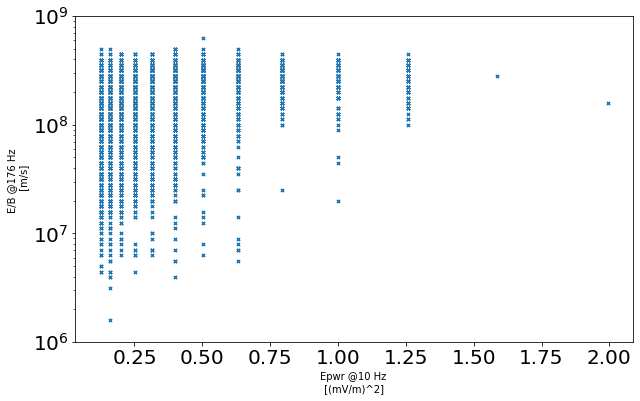

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('E/B @176 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

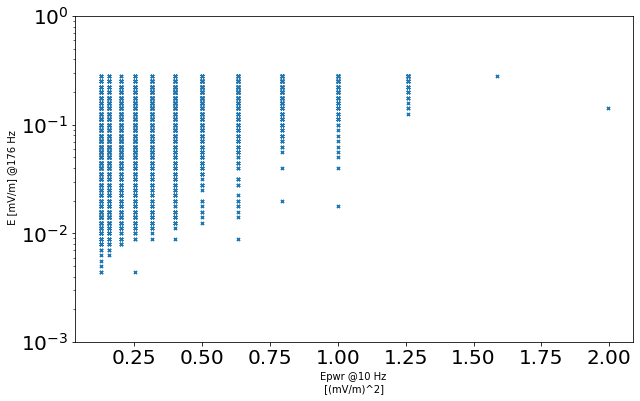

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_176Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @176 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

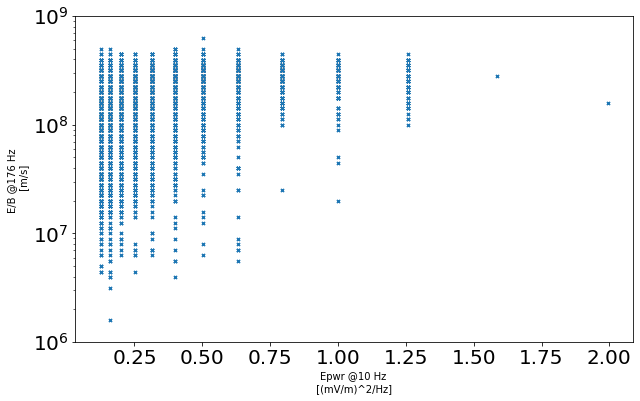

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @176 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output10')
plt.show()

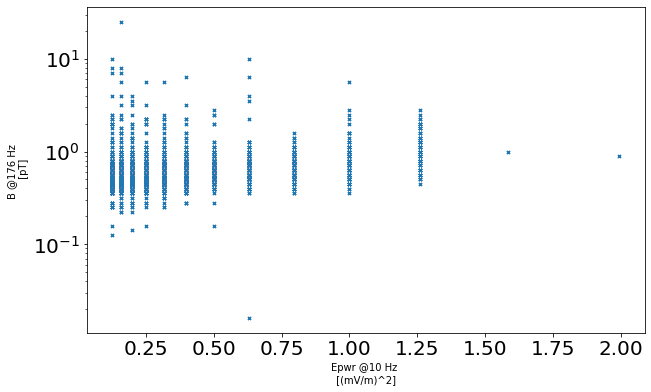

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @176 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

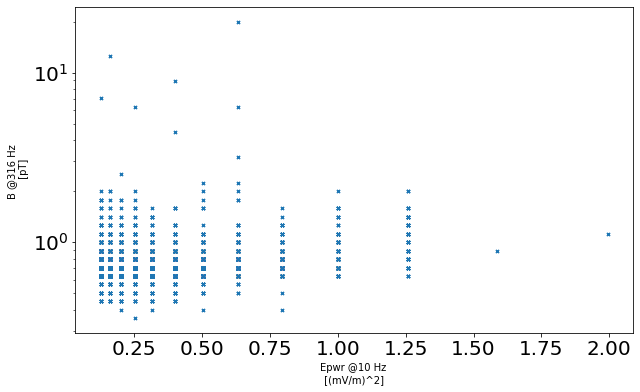

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_316Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @316 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

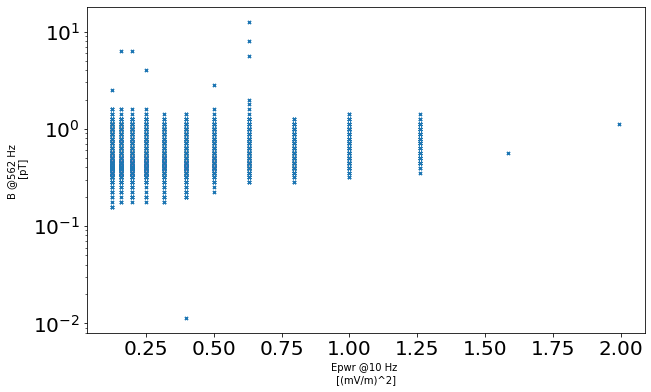

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_562Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @562 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

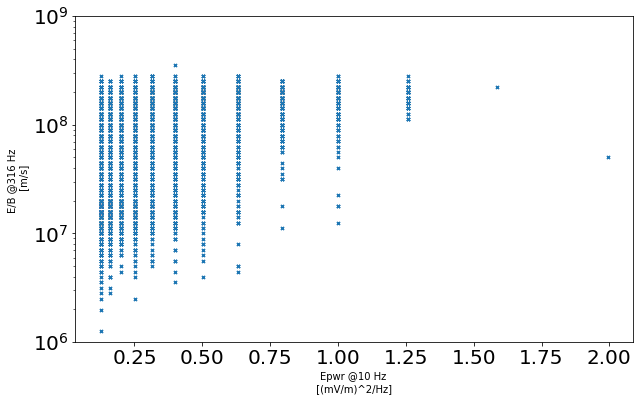

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_316Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @316 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output20')
plt.show()

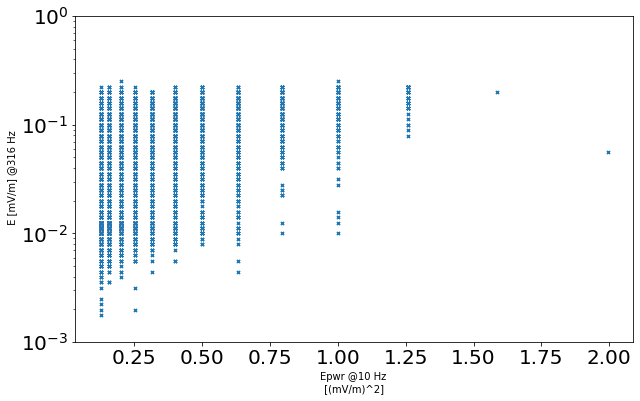

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_316Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @316 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

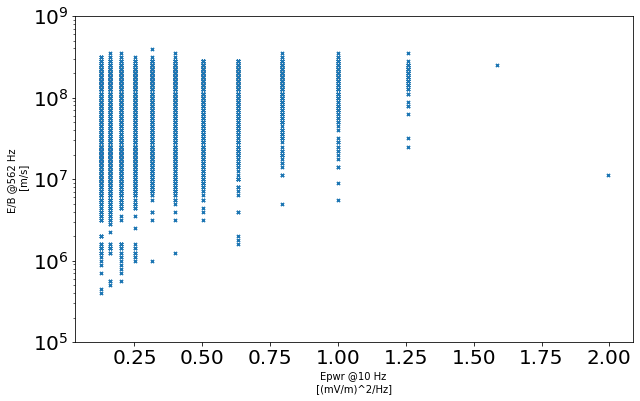

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_562Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @562 Hz \n [m/s]')
plt.ylim(1e5, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output30')
plt.show()

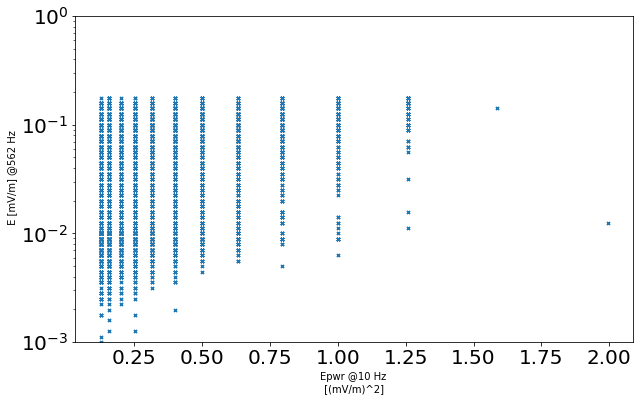

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_562Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @562 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

# An estimation of the doppler shift effect  



In [28]:
import numpy as np
Ne = np.array([60, 71, 128, 225, 173, 47])*1e6
fpe = 9*np.sqrt(Ne)
H_number_ratio = np.array([0.46, 0.30, 0.24, 0.14, 0.32, 0.29])
H_vth = np.array([29.4, 33.9, 23.2, 24.2, 30.3, 57.7])*1e3
O_number_ratio = np.array([0.43, 0.64, 0.68, 0.76, 0.56, 0.52])
O_vth = np.array([6.09, 7.33, 6.86, 4.78, 7.07, 14.1])*1e3
vth = H_number_ratio*H_vth + O_number_ratio*O_vth
fcO = np.array([8.53, 5.62, 5.26, 6.39, 6.28, 5.76])
electron_skin_depth = 3e8 / (2*np.pi*fpe)
ion_gyro_radii = vth/(2*np.pi*fcO)

print('fpe:', fpe)
print(vth)
print('electron skin depth:',electron_skin_depth)
print('ion gyro radius:', ion_gyro_radii)

fpe: [ 69713.70023173  75835.34795859 101823.37649086 135000.
 118376.51794169  61700.89140361]
[16142.7 14861.2 10232.8  7020.8 13655.2 24065. ]
electron skin depth: [684.89382673 629.60722424 468.914748   353.67765132 403.34420844
 773.83781403]
ion gyro radius: [301.19466587 420.86004275 309.61990526 174.86620101 346.06569728
 664.94161554]


In [29]:
import numpy as np
Ne = np.array([60, 71, 128, 225, 173, 47])*1e6
fpe = 9*np.sqrt(Ne)
H_number_ratio = np.array([0.46, 0.30, 0.24, 0.14, 0.32, 0.29])
H_vth = np.array([29.4, 33.9, 23.2, 24.2, 30.3, 57.7])*1e3
O_number_ratio = np.array([0.43, 0.64, 0.68, 0.76, 0.56, 0.52])
O_vth = np.array([6.09, 7.33, 6.86, 4.78, 7.07, 14.1])*1e3
vth = H_number_ratio*H_vth + O_number_ratio*O_vth
fcO = np.array([8.53, 5.62, 5.26, 6.39, 6.28, 5.76])

electron_skin_depth = 3e8 / (2*np.pi*fpe)
ion_gyro_radii = vth/(2*np.pi*(O_number_ratio*fcO + H_number_ratio*120))

print('fpe:', fpe)
print(vth)
print('electron skin depth:',electron_skin_depth)
print('ion gyro radius:', ion_gyro_radii)

fpe: [ 69713.70023173  75835.34795859 101823.37649086 135000.
 118376.51794169  61700.89140361]
[16142.7 14861.2 10232.8  7020.8 13655.2 24065. ]
electron skin depth: [684.89382673 629.60722424 468.914748   353.67765132 403.34420844
 773.83781403]
ion gyro radius: [ 43.64331834  59.73294408  50.30147209  51.59652687  51.84776936
 101.33730488]


In [7]:
help(vth)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec